<h1>Tower Battery Documentation</h1>

<h2>Load Calculation</h2>
To calculate the load, each components current draw was measured, which was then converted to watts. The power draw would then be divided by the efficiency of the 5v or 3v3 dc-dc converter depending on the component. The tower is estimated to need around 12W of power to run. <br /> <br />
Component Measurements:

- Upcore: 1.6A * 5V = 8W (maximum power expected)
- GPS/Magnetometer: ~50mA * 5V = 250mW 
- Sik Radio: 100mA * 5V = 500mW 
- USRP B200mini: attached to upcore during testing
- LNA: 80mA * 5V = 400mW 


Converter Adjusted power:
- 5V: (8W + 250mW + 500mW + 400mW) / 0.8 = 11.4375 W
- 3.3V: 400mW / 0.73 = 0.548 W 
- Total: 0.548 + 11.4375 = 11.9855 W


<h2>System Model</h2>
The power system consists of 2 solar panels in series connected to a mppt charge controller, which is connected to both a deep cycle lead acid battery and the tower electronics. During the day, the solar panel will supply power and charge the lead acid battery, while the battery will supply power during the night. The simulation works by averaging the power outputted over a time interval based off of the input data, calculating system losses over this period, multiplying the power by the time interval length to get energy, and then adding this energy to the capacity of the system while subtracting the energy consumed by the load over this same period.<br />
<h4> Solar Panels </h4>
The reason why 2 solar panels in series was chosen was because the charge controller can only manage charging the battery when the voltage is above a certain threshold, which varies by charge controller, but can be between 9-14V. If the panel is outputting a lower voltage, then the charge controller is unable to charge the battery. By putting 2 panels in series, the output voltage is higher, meaning the batteries are charging more often. Additionally, a single 100W solar panel does not supply enough power for most locations, so 2 100W panels or a 200W panel would be needed regardless. <br />
For the simulation, the solar panels were modelled using the equation: $$ P_{output} (W) = Solar Radiation (W/m^2) * Area (m^2) * Panel Efficiency * (1 -|T_{optimal} - T_{actual}| * T_{coeff})$$
Additionally, the maximum output of the panel can be included, as panels cannot output more than this rating. In the simulation, if the panel is outputting more than the maximum, it will be automatically set to this value.
<h4>Charge Controllers</h4>
Charge controllers are necessary for solar panel systems, as they will ensure that the battery will not be damaged while charging. There are 2 types, which are PWM and MPPT controllers. PWM controllers are much less efficient, as around 25% of the energy from the panel is lost while charging (as opposed to 5% for MPPT), but are also aroudn 40-50\$ cheaper for each controller. However, this extra 20% of efficiency lost would mean that another solar panel would be needed to supply enough power, which would cost an extra 100\$, meaning the cost benefits would not be worth it, which is why a MPPT controller was chosen. <br />
In the simulation, the charge controller affects the input power in 2 ways, through its efficiency and its minimum input voltage. The efficiency is a straightforward multiplier to how much power is entering the system. The minimum input voltage is derived from the power of the solar panel. You can reference the solar panel data sheet and look for the curve characteristics chart. Using this chart, you can find the voltage at which the charge controller no longer works correctly, and find the power output at this voltage. Then, during the simulation, any panel output value which is below this threshold can be thrown out, to simulate how the charge controller would not work due to low voltage.
<h4>Lead Acid Battery</h4>
The type of battery needed is a 12V deep cycle lead acid battery. The main reason this battery was chosen was its cost, as lead acid batteries are the cheapest high capacity batteries (when compared to lithium for example). Something important to note is that the lead acid batteries will be potentially discharged to 100%, which would damage the battery. This is not an issue for a few reasons. First, when using a depth-of-discharge (DOD) of 100% consistently, the battery life drops from 500 cycles to 200 cycles, however, 200 cycles (or around 200 days) is plenty of time for the system to be deployed multiple times. Additionally, the battery is sized for the least sunny period, which means that it will reach a DOD close to 100% during this time, but will usually have a lower DOD. This means that the battery will not take as much damage, meaning that the 200 cycles is a lower bounds estimate. <br />
The battery uses a charge efficiency of 85% by default, which means that 15% of the charging energy is lost due to heat, which is pretty standard for a lead acid battery. The battery also can only store Amp-hours * (12.6-10.8)/2 watt-hours of energy. The (12.6-10.8)/2 is used to represent the average voltage of the battery, which gives an approximate total energy that can be stored in the battery.


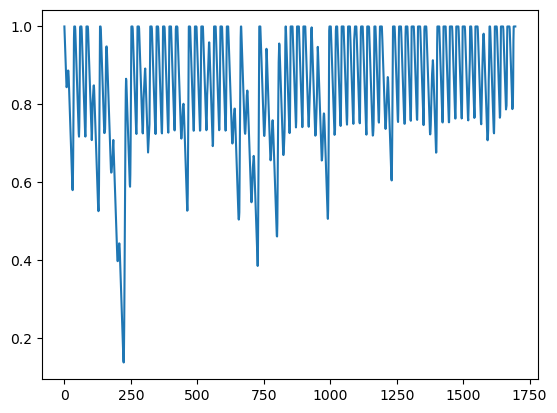

System successfully works under given conditions


In [90]:
import csv
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

# instructions:
# 1. download data for selected location from https://ambientweather.net in csv file
# 2. save data in same folder as sim notebook
# 3. update hardware information constants below, can find these in data sheets for components
# ***If using data from different source, make sure that column variables match each columns' data 
# in the csv file and that all units match

# change these depending on what column in the csv contains what data
date_col = 1 # date is stored as 2020-01-01 20:15:16
temp_col = 2 # temperature stored as integer in F
sunl_col = 9 # sunlight is stored as integer in W/m^2

# component values, see datasheets for each component to determine
# solar panel
optimal_temp = 113 # measured in F
temp_coeff = 0.39 # measured in %/F
area = 0.535934412 # measured in m^2
panel_efficiency = 0.198 
panel_max_output = 100 # measured in watts
number_of_panels = 2

# charge controller
charge_controller_efficiency = 0.95 
minimum_charging_power = 5 # measured in watts

# battery
battery_capacity = 50 # measured in AH
battery_efficiency = 0.85 
avg_voltage = (12.6 + 10.8) / 2 
max_capacity = battery_capacity * avg_voltage # measured in WH

# load
load_power = 11.99 # measured in watts

# system
system_losses = 0.1 # extra 10% overhead for like wire
fail_threshould = 0.1 # % charge of battery where system could fail

date_arr = []
temp_arr = []
sunl_arr = []
time_diff_arr = []
coeff_arr = []
panel_output_arr = []
time_arr = [0.0]
percent_capacity = [1]
wh_capacity = [avg_voltage * battery_capacity]

# read data and insert into arrays
with open('weather_data.csv', mode = 'r') as file:
    csvFile = csv.reader(file)
    count = 0
    for line in csvFile:
        date_arr.insert(0, line[date_col])
        temp_arr.insert(0, line[temp_col])
        sunl_arr.insert(0, line[sunl_col])

date_arr.pop()
temp_arr.pop()
sunl_arr.pop()

# convert data values from strings to floats after header removed
for idx in range(len(date_arr)):
    temp_arr[idx] = float(temp_arr[idx])
    sunl_arr[idx] = float(sunl_arr[idx])

# calculate time difference between each data point and store
for idx in range(len(date_arr) - 1): 
    initial_time = datetime.strptime(date_arr[idx], '%Y-%m-%d %H:%M:%S')
    final_time = datetime.strptime(date_arr[idx+1], '%Y-%m-%d %H:%M:%S')
    difference = final_time - initial_time
    d_h = (difference.total_seconds() / 3600.0)
    time_diff_arr.append(d_h)

# calculate temperature adjust coefficient
for idx in range(len(temp_arr)):
    coeff_arr.append(1 - abs(temp_arr[idx] - optimal_temp) * temp_coeff / 100)


# calculate power outputted by solar panels
for idx in range(len(temp_arr)):
    output = sunl_arr[idx] * area * panel_efficiency * coeff_arr[idx]
    
    # model maximum output of solar panel
    if output > panel_max_output:
        output = panel_max_output
    output = output * number_of_panels

    # model charge controller 
    if output < minimum_charging_power:
        output = 0
    output = output * charge_controller_efficiency
    panel_output_arr.append(output)

# generate time values in hours
for idx in range(len(time_diff_arr)):
    time_arr.append(time_arr[idx] + time_diff_arr[idx])

if_system_fails = 0

# calculate voltage of 
for idx in range(len(time_diff_arr)):
    next_incr = wh_capacity[idx] - load_power * time_diff_arr[idx] + (panel_output_arr[idx] + panel_output_arr[idx+ 1]) / 2 * battery_efficiency * time_diff_arr[idx]
    if next_incr > max_capacity:
        next_incr = max_capacity
    elif next_incr < 0:
        next_incr = 0
    wh_capacity.append(next_incr)
    percent_capacity.append(next_incr * 1.0 / max_capacity)

    if percent_capacity[len(percent_capacity) - 1] <= fail_threshould:
        if_system_fails = 1

x_time = np.array(time_arr)
y_pow = np.array(percent_capacity)
plt.plot(x_time, y_pow)
plt.show() 

if if_system_fails == 1:
    print("System does not provide enough power, may potentially shut off under poor conditions")
elif if_system_fails == 0:
    print("System successfully works under given conditions")
